<a href="https://colab.research.google.com/github/lloydoad/disaster-tweet-classifier/blob/master/disaster_tweet_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [2]:
!pip install sentencepiece

     |████████████████████████████████| 1.1MB 13.9MB/s 


In [3]:
import string
import spacy
import nltk
import pandas as pd
import numpy as np
import regex as re
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [4]:
import keras
import sklearn
import tokenization
import tensorflow_hub as hub
from keras import layers
from keras import Model
from keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import ModelCheckpoint, Callback
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling1D
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import precision_score, recall_score, f1_score 

# Exploration

In [5]:
train_url_path = 'https://raw.githubusercontent.com/lloydoad/disaster-tweet-classifier/master/datasets/train.csv'
test_url_path = 'https://raw.githubusercontent.com/lloydoad/disaster-tweet-classifier/master/datasets/test.csv'
train = pd.read_csv(train_url_path, error_bad_lines=False)
test = pd.read_csv(test_url_path, error_bad_lines=False)
train = train.drop('id', axis=1)
test = test.drop('id', axis=1)

In [6]:
train_length, test_length, feature_count = train.shape[0], test.shape[0], test.shape[1]
print('Number of features: ', feature_count)
print('Number of instances in training set: ', train_length)
print('Number of instances in test set: ', test_length)
print('Total number of instances:', train_length + test_length)

Number of features:  3
Number of instances in training set:  7613
Number of instances in test set:  3263
Total number of instances: 10876


In [7]:
print('First 10 train datapoints')
train.head(10)

First 10 train datapoints


,keyword,location,text,target
0,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,NaN,NaN,There's an emergency evacuation happening now ...,1
9,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [8]:
print('First 10 test datapoints')
test.head(10)

First 10 test datapoints


,keyword,location,text
0,NaN,NaN,Just happened a terrible car crash
1,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
5,NaN,NaN,We're shaking...It's an earthquake
6,NaN,NaN,They'd probably still show more life than Arse...
7,NaN,NaN,Hey! How are you?
8,NaN,NaN,What a nice hat?
9,NaN,NaN,Fuck off!


In [9]:
train_missing_keywords, test_missing_keywords = train.keyword.isna().sum(), test.keyword.isna().sum()
train_missing_location, test_missing_location = train.location.isna().sum(), test.location.isna().sum()
print('Number of missing keywords: Train {}, Test {}'.format(train_missing_keywords, test_missing_keywords))
print('Number of missing location: Train {}, Test {}'.format(train_missing_location, test_missing_location))

Number of missing keywords: Train 61, Test 26
Number of missing location: Train 2533, Test 1105


In [10]:
for dataFrame in [train, test]:
  dataFrame.keyword.fillna('no_keywords', inplace=True)
  dataFrame.location.fillna('no_location', inplace=True)

Looking at the number of missing values for keywords and location for both training and test set, we see that there are more missing locations (**~33%**) than keywords (**~0.8%**)
Unavailable keyword or location features are explicitly stated. 

In [11]:
train.sample(20)

,keyword,location,text,target
4631,injury,no_location,incident with injury:I-495 inner loop Exit 31...,1
2418,derailed,US,Breakfast links: Work from home: Derailed: An ...,1
3404,explode,"New Orleans, Louisiana",See these guys reaching the front foot out loa...,0
2191,debris,no_location,Plane debris discovered on Reunion Island belo...,1
3157,emergency,no_location,Loans until settlement day ??ÛÏ emergency mon...,0
3850,flames,hell,@gilderoy i wish i was good enough to add flam...,1
2493,desolate,Macclesfield,@binellithresa TY for the follow Go To http://...,1
1445,casualty,no_location,AM Best Special Report: How Metrics Correlate ...,0
4116,hailstorm,"Suginami-ku, Tokyo, Japan",Severe weather and a rare hailstorm pummel Bos...,1
2281,demolish,South Africa,Yea so I'm gonna demolish all those boundaries...,0


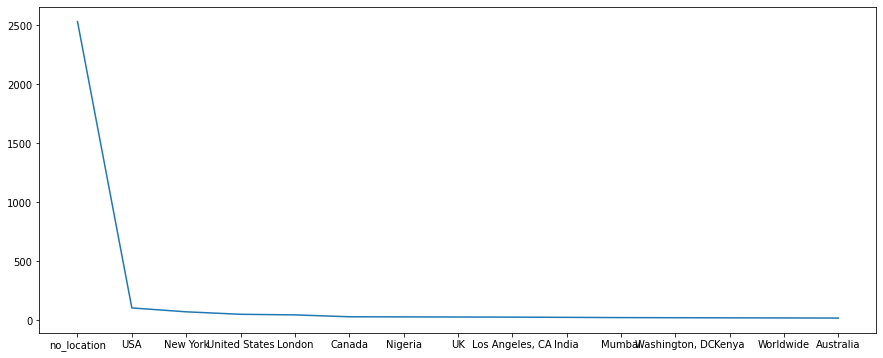

In [12]:
top_15_locations = train.groupby(['location']).count().text.sort_values(ascending=False)[:15]
figure(figsize=(15,6))
plt.plot(top_15_locations)
plt.show()

The frequency per unique location is very low. 
There's also multiple locations with different representations that mean the same thing; for example United States and USA.
Location may not be an important factor in classifying texts due to it being varied and 1/3 of the datapoints not having any location feature at all.

# Preprocessing

First stage of processing for NLP is cleaning the tweet to take out stop words, http links, and extra characters like punctuations or trailing spaces.

In [13]:
nlp = spacy.load('en')
sp = spacy.load('en_core_web_sm')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [14]:
spacy_stop_words = nlp.Defaults.stop_words
nltk_stop_words = stopwords.words('english')
all_stop_words = spacy_stop_words.union(nltk_stop_words)
print('Number of stop words: ', len(all_stop_words))

Number of stop words:  382


In [15]:
def clean(tweet):
  # Remove link portion of attachments in tweet
  tweet = re.sub('https?:\/\/t.co\/[A-Za-z0-9]*', '', tweet)
  
  # Remove stop words
  tweet = [word for word in word_tokenize(tweet) if not word.lower() in all_stop_words]
  tweet = ' '.join(tweet)

  # # Remove puntuations
  tweet = tweet.translate(str.maketrans('', '', string.punctuation))

  # # Remove extra space
  tweet = re.sub("\s+", ' ', tweet)

  return tweet

In [16]:
test_tweet = train.sample(1).values[0,2]
print(
    'Cleaning example\nOriginal Tweet:', test_tweet, 
    'Cleaned Tweet', clean(test_tweet),
    sep='\n'
    )

Cleaning example
Original Tweet:
[Reuters] Debris confirmed from MH370; relatives hope for discovery of crash site http://t.co/DFYaSVj7NF
Cleaned Tweet
 Reuters Debris confirmed MH370 relatives hope discovery crash site


In [17]:
train['clean_text'] = train.text.apply(lambda x:clean(x))
test['clean_text'] = test.text.apply(lambda x:clean(x))
train.sample(5)

,keyword,location,text,target,clean_text
1452,casualty,"Hospital, bc of SKH vid.",Social Casualty #MTVHottest 5SOS,0,Social Casualty MTVHottest 5SOS
7458,wounds,Alex/Mika/Leo|18|he/she/they,@ego_resolution im glad. My gay can heal 1000 ...,0,egoresolution im glad gay heal 1000 wounds
6734,thunderstorm,no_location,A STRONG THUNDERSTORM WILL AFFECT CENTRAL HALI...,1,STRONG THUNDERSTORM AFFECT CENTRAL HALIFAX COU...
4342,hijack,no_location,@welshninja87 click on the tag there's lots of...,0,welshninja87 click tag lots RT hijack hashtag
533,avalanche,no_location,driving the avalanche after having my car for ...,1,driving avalanche car week like driving tank


Second stage is creating the embeddings that will be fed into our model for classifications

In [18]:
FullTokenizer = tokenization.FullTokenizer

In [19]:
BERT_BASE_MODEL_HUB = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'
BERT_BASE_DISC = 'Base_uncased'

# Two different pretrained layers. A base case layer for working out parameters
# and a larger layer for final classification
bert_base_layer = hub.KerasLayer(BERT_BASE_MODEL_HUB, trainable=False)

# Selected BERT model only takes lowercase strings
to_lower_case = bert_base_layer.resolved_object.do_lower_case.numpy()
base_vocabulary_file = bert_base_layer.resolved_object.vocab_file.asset_path.numpy()
base_tokenizer = FullTokenizer(base_vocabulary_file, to_lower_case)

In [20]:
def encode_tweet(text, tokenizer=base_tokenizer):
  # CLS and SEP are attached to end of tokenized word for storing classification weights
  # and separating words respectively
  tokenized_tweet = tokenizer.convert_tokens_to_ids(['[CLS]'] + tokenizer.tokenize(text) + ['[SEP]'])
  return tokenized_tweet

In [21]:
max_token_length = 0
def encode_list(tweet_list=train.clean_text, tokenizer=base_tokenizer, force_max_len=None):
  tokenized_tweets = [encode_tweet(tweet) for tweet in tweet_list]
  if force_max_len:
    max_len = force_max_len
  else:
    max_len = len(max(tokenized_tweets, key = len))
  
  tokens = []
  masks = []
  segments = []

  for token_tweet in tokenized_tweets:
    length = len(token_tweet)
    padded_token_tweet = token_tweet + ([0] * (max_len - length))
    padded_token_mask = (length * [1]) + ([0] * (max_len - length))
    segment = [0] * max_len

    tokens.append(padded_token_tweet)
    masks.append(padded_token_mask)
    segments.append(segment)
  
  print('Maximum token length: ', max_len)
  max_token_length = max_len
  return np.array(tokens), np.array(masks), np.array(segments)

def encode_dataset(dataset=train, tokenizer=base_tokenizer, force_max_len=None):
  return encode_list(dataset.clean_text, tokenizer=tokenizer, force_max_len=force_max_len)

# Classifier

Create classification model that defaults to the following parameters: BERT base layer, 0.0001 learning rate, sigmoid activation in the last layer, with Adam optimizer and BCE loss function measuring accuracy

In [24]:
def create_model(bert_layer=bert_base_layer,
                 name='default_function_model',
                 bert_trainable=False,
                 add_hidden_layer=True,
                 input_length=128,
                 lr = 0.0001, 
                 momentum = 0.8,
                 activation='sigmoid', 
                 optimizer='Adam',
                 metrics=['accuracy'], 
                 loss = 'binary_crossentropy'):
  if bert_trainable:
    print('Will also train bert layers')
  bert_layer.trainable = bert_trainable

  # Define the shape for the input layer
  input_tokens = Input(shape=(input_length,), dtype='int32', name='input_tokens')
  input_masks = Input(shape=(input_length,), dtype='int32', name='input_masks')
  input_segments = Input(shape=(input_length,), dtype='int32', name='input_segments')
  pooled_output, sequence_output = bert_layer([input_tokens, input_masks, input_segments])
  
  cls_layer = sequence_output[:, 0, :]
  # Define hidden and output layer
  if add_hidden_layer:
    print('Adding hidden layer with 256 units on top of bert layer')
    hidden = Dense(256, activation=activation)(cls_layer)
    hiddenDropout = Dropout(0.5)(hidden)
    output = Dense(1, activation=activation)(hiddenDropout)
  else:
    output = Dense(1, activation=activation)(cls_layer)

  # Assemble model
  model = Model(
      inputs=[input_tokens, input_masks, input_segments], 
      outputs=output,
      name=name
      )
  
  print('Using {} optimizer'.format(optimizer))
  if optimizer == 'Adam':
    optimizer = Adam(learning_rate=lr)
  elif optimizer == 'RMSProp':
    optimizer = RMSprop(learning_rate=lr)
  elif optimizer == 'SGD':
    optimizer = SGD(learning_rate=lr, momentum=momentum)
  
  model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
  return model

def get_model(
    name='default_model', 
    word_length=128,
    optimizer='Adam',
    add_hidden_layer=True,
    train_bert=False
    ):
  checkpoint = ModelCheckpoint(name + '.h5', monitor='val_loss', save_best_only=True)
  return create_model(
      name=name, 
      input_length=word_length,
      bert_trainable=train_bert,
      add_hidden_layer=add_hidden_layer,
      optimizer=optimizer
      )

For the finetuning, a default model is trained for 1 epoch to monitor validation accuracy and hyper-parameters

In [25]:
X = encode_dataset(dataset=train, tokenizer=base_tokenizer)
y = train.target
max_word_length = X[0].shape[1]
_ = get_model('prep_model', word_length=max_word_length).fit(X, y, shuffle=True, validation_split=0.35, batch_size=32, epochs=1)

Maximum token length:  53
Adding hidden layer with 256 units on top of bert layer
Using Adam optimizer
155/155 [==============================] - 31s 199ms/step - loss: 0.6908 - accuracy: 0.5903 - val_loss: 0.5737 - val_accuracy: 0.7437


Second possible model takes uses a different optimizer (RMSProp)

In [26]:
X = encode_dataset(dataset=train, tokenizer=base_tokenizer)
get_model('prep_model_rmsprop', word_length=max_word_length, optimizer='RMSProp').fit(X, y, shuffle=True, validation_split=0.35, batch_size=32, epochs=1)

Maximum token length:  53
Adding hidden layer with 256 units on top of bert layer
Using RMSProp optimizer
155/155 [==============================] - 31s 200ms/step - loss: 0.6566 - accuracy: 0.6279 - val_loss: 0.5529 - val_accuracy: 0.7553


Third possible model takes uses a different optimizer (SGD)

In [28]:
X = encode_dataset(dataset=train, tokenizer=base_tokenizer)
get_model('prep_model_rmsprop', word_length=max_word_length, optimizer='SGD').fit(X, y, shuffle=True, validation_split=0.35, batch_size=32, epochs=1)

Maximum token length:  53
Adding hidden layer with 256 units on top of bert layer
Using SGD optimizer
155/155 [==============================] - 30s 196ms/step - loss: 0.7890 - accuracy: 0.4907 - val_loss: 0.6804 - val_accuracy: 0.5921


For the full model, we will use cross-validation fold to improve performance for our dataset. We will also use Stochastic Gradient Descent for our optimizer since it had the best performance from our preliminary tests.

In [29]:
seed_for_split = 1996
number_of_folds = 2
stratified_kf = StratifiedKFold(n_splits=number_of_folds, random_state=seed_for_split, shuffle=True)

print('We use the keyword as a key for spliting our train data to get an even spread of keywords across both the training dataset and the validation dataset')
for fold, (trn_idx, val_idx) in enumerate(stratified_kf.split(train.clean_text, train.target), 1):
  train_set = train.loc[trn_idx]
  train_val = train.loc[trn_idx]
  print('\nFold {} Training dataset = {} - Validation dataset = {}'.format(fold, train_set.clean_text.shape, train_val.clean_text.shape))
  print('Unique keyword Count = Train Set {} - Validation Set {}'.format(train_set.keyword.nunique(), train_val.keyword.nunique()))    

We use the keyword as a key for spliting our train data to get an even spread of keywords across both the training dataset and the validation dataset

Fold 1 Training dataset = (3806,) - Validation dataset = (3806,)
Unique keyword Count = Train Set 222 - Validation Set 222

Fold 2 Training dataset = (3807,) - Validation dataset = (3807,)
Unique keyword Count = Train Set 222 - Validation Set 222


Classification Report class is created to moniter accuracy and progress during epochs. This covers more measures in details as compared the usual accuracy for default fit function.
[ClassificationReport code credit](https://colab.research.google.com/github/goswami-rahul/machine-learning/blob/master/UnderstandingMetrics.ipynb)

In [30]:
class ClassificationReport(Callback):
  def __init__(self, train_data=(), validation_data=()):
    super(Callback, self).__init__()
    
    self.X_train, self.y_train = train_data
    self.train_precision_scores = []
    self.train_recall_scores = []
    self.train_f1_scores = []
    
    self.X_val, self.y_val = validation_data
    self.val_precision_scores = []
    self.val_recall_scores = []
    self.val_f1_scores = [] 
              
  def on_epoch_end(self, epoch, logs={}):
    train_predictions = np.round(self.model.predict(self.X_train, verbose=0))        
    train_precision = precision_score(self.y_train, train_predictions, average='macro')
    train_recall = recall_score(self.y_train, train_predictions, average='macro')
    train_f1 = f1_score(self.y_train, train_predictions, average='macro')
    self.train_precision_scores.append(train_precision)        
    self.train_recall_scores.append(train_recall)
    self.train_f1_scores.append(train_f1)
    
    val_predictions = np.round(self.model.predict(self.X_val, verbose=0))
    val_precision = precision_score(self.y_val, val_predictions, average='macro')
    val_recall = recall_score(self.y_val, val_predictions, average='macro')
    val_f1 = f1_score(self.y_val, val_predictions, average='macro')
    self.val_precision_scores.append(val_precision)        
    self.val_recall_scores.append(val_recall)        
    self.val_f1_scores.append(val_f1)
    
    print('\nEpoch: {} - Training Precision: {:.6} - Training Recall: {:.6} - Training F1: {:.6}'.format(epoch + 1, train_precision, train_recall, train_f1))
    print('Epoch: {} - Validation Precision: {:.6} - Validation Recall: {:.6} - Validation F1: {:.6}'.format(epoch + 1, val_precision, val_recall, val_f1)) 

In [31]:
full_model_name = 'full_model'
number_of_epochs = 10
trained_models = []
scores = {}

def train_main_models():
  for fold, (trn_idx, val_idx) in enumerate(stratified_kf.split(train.clean_text, train.target), 1):
    print('Training Fold ', fold)
    train_set = train.loc[trn_idx]
    train_val = train.loc[trn_idx]

    # Split into train and validation sets
    X_train, y_train = encode_list(train_set.clean_text), train_set.target
    X_val, y_val = encode_list(train_val.clean_text), train_val.target 

    # Train and monitor accuracy, recall, and f1-score
    metrics = ClassificationReport(train_data=(X_train, y_train), validation_data=(X_val, y_val))
    curr_model_name = full_model_name + '_{}'.format(fold)
    model = get_model(name=curr_model_name, word_length=max_word_length, optimizer='SGD', add_hidden_layer=False, train_bert=True)
    model.fit(x=X_train, y=y_train, validation_data=(X_val, y_val), callbacks=[metrics], epochs=number_of_epochs, batch_size=32)

    # Add model to ensemble
    trained_models.append(model)
    print('Current models trained', len(trained_models))

    # Save scores from metrics
    scores[fold] = {
      'train': {
        'precision': metrics.train_precision_scores,
        'recall': metrics.train_recall_scores,
        'f1': metrics.train_f1_scores                    
      },
      'validation': {
        'precision': metrics.val_precision_scores,
        'recall': metrics.val_recall_scores,
        'f1': metrics.val_f1_scores                    
      }
    }
  
  print('Total number of models trained: ', len(trained_models))

# Start training
train_main_models()

Training Fold  1
Maximum token length:  53
Maximum token length:  53
Will also train bert layers
Using SGD optimizer
Epoch 1/10
119/119 [==============================] - ETA: 0s - loss: 0.6518 - accuracy: 0.6287
Epoch: 1 - Training Precision: 0.744482 - Training Recall: 0.731232 - Training F1: 0.734455
Epoch: 1 - Validation Precision: 0.744482 - Validation Recall: 0.731232 - Validation F1: 0.734455
119/119 [==============================] - 88s 739ms/step - loss: 0.6518 - accuracy: 0.6287 - val_loss: 0.5674 - val_accuracy: 0.7457
Epoch 2/10
119/119 [==============================] - ETA: 0s - loss: 0.5395 - accuracy: 0.7530
Epoch: 2 - Training Precision: 0.77264 - Training Recall: 0.776898 - Training F1: 0.773693
Epoch: 2 - Validation Precision: 0.77264 - Validation Recall: 0.776898 - Validation F1: 0.773693
119/119 [==============================] - 87s 727ms/step - loss: 0.5395 - accuracy: 0.7530 - val_loss: 0.4899 - val_accuracy: 0.7761
Epoch 3/10
119/119 [=========================

# Evaluation

A separate submissions dataset is downloaded to get the target classes for measuring prediction accuracy. The test dataset is then filtered to only contain the cleaned text and the targets.

In [32]:
test_target_url = 'https://raw.githubusercontent.com/lloydoad/disaster-tweet-classifier/master/datasets/test_target.csv'
test_target = pd.read_csv(test_target_url, error_bad_lines=False).drop(['id'], axis=1)
prepped_test = pd.concat([test])
prepped_test['target'] = test_target.astype(int)
prepped_test.drop(['keyword', 'location', 'text'], axis=1, inplace=True)
print('Number of missing target values: ', prepped_test.target.isna().sum())
prepped_test.sample(5)

Number of missing target values:  0


,clean_text,target
865,Waige driving like Badass ScorpionPilot Cyclon...,1
1324,Children traumatised Nepal earthquake educate...,1
2544,CokeBoys yo best screamed watched snap chat s...,0
917,Microsoft Xbox 360 console RRoD red ring death...,0
1050,people ride Metro whywebike bikecommute Dysfun...,0


By combining all the models that have been fully trained, we are able to create an ensemble for with a prediction accuracy approximately above **80%**.

In [33]:
def predict(test=prepped_test, tokenizer=base_tokenizer, force_max_len=max_word_length):
  X_test = encode_dataset(dataset=test, tokenizer=tokenizer, force_max_len=force_max_len)
  pred_y = np.zeros((test.target.shape[0], 1))
  numberOfModels = len(trained_models)
  for model in trained_models:
    pred_y += model.predict(X_test) / numberOfModels
  return pred_y
predicted_y = predict()

Maximum token length:  53


In [64]:
pred_values = np.round(predicted_y).astype('int').reshape(1,-1)[0]
true_values = prepped_test.target.values
score = sklearn.metrics.f1_score(true_values, pred_values, average='micro')
print('The F1 Score of the prediction:', score)

The F1 Score of the prediction: 0.8194912657064052


Plotting the sum of the accuracy scores for all folds shows a gradual increase over time with subsequent folds performing better than previous folds. 

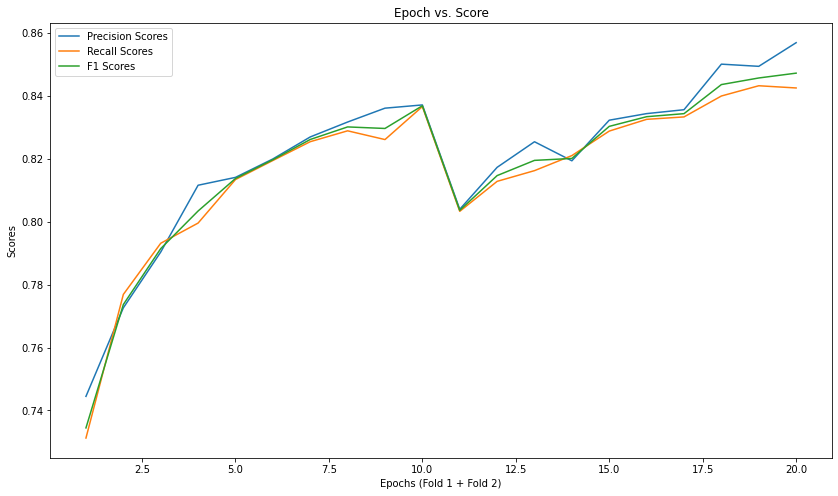

In [71]:
def plot_scores():
  rangeOfEpochs = np.arange(1, (number_of_epochs * number_of_folds) + 1)
  figure(figsize=(14,8))
  fig.suptitle('Epoch vs. Score')

  precision_values = []
  recall_values = []
  f1_values = []

  for fold in scores:
    foldValues = scores[fold]
    validationValues = foldValues['validation']
    precision_values += validationValues['precision']
    recall_values += validationValues['recall']
    f1_values += validationValues['f1']

  plt.plot(rangeOfEpochs, precision_values, label='Precision Scores')
  plt.plot(rangeOfEpochs, recall_values, label='Recall Scores')
  plt.plot(rangeOfEpochs, f1_values, label='F1 Scores')
  plt.xlabel('Epochs (Fold 1 + Fold 2)')
  plt.ylabel('Scores')
  plt.title('Epoch vs. Score')
  plt.legend()
  plt.show()

plot_scores()

# References

* https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
* https://www.kaggle.com/c/nlp-getting-started/overview
* https://www.kaggle.com/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert#8.-Test-Set-Labels
* https://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/
* https://mccormickml.com/2019/07/22/BERT-fine-tuning/
* https://www.searchenginejournal.com/bert-explained-what-you-need-to-know-about-googles-new-algorithm/337247/
* https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270